In [33]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, matthews_corrcoef
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

# Read the data
results = pd.read_csv('results.csv', delimiter=',') 
results_UC = pd.read_csv('unit_comitment.csv', delimiter=',')

In [34]:
results.head()

hour  generation 1  generation 2  generation 3  wind generation 1  \
0     0         100.0     10.000000     10.000000               0.67   
1     1         100.0     28.682870     10.603147               0.00   
2     2         100.0     13.962833     20.713147               0.00   
3     3         100.0     17.315920     10.413147               0.00   
4     4         100.0     17.779246     18.943147               0.00   

   wind generation 2  load 1  load 2  load 3  epsilon 1  delta 1  epsilon 2  \
0              14.65    8.66   72.06   54.60        0.0      0.0        0.0   
1               2.74    8.83   87.35   56.23        0.0      0.0        0.0   
2               0.00    8.31   64.08   66.34        0.0      0.0        0.0   
3               5.22   11.12   68.35   56.04        0.0      0.0        0.0   
4               3.47    9.24   70.86   64.57        0.0      0.0        0.0   

   delta 2  epsilon 3  delta 3  epsilon 4  delta 4  epsilon 5    delta 5  \
0      0.0        0.0      0.0        0.0      0.0        0.0   0.000000   
1      0.0        0.0      0.0        0.0      0.0        0.0  10.383983   
2      0.0        0.0      0.0        0.0      0.0        0.0   4.054020   
3      0.0        0.0      0.0        0.0      0.0        0.0   2.560933   
4      0.0        0.0      0.0        0.0      0.0        0.0   4.477607   

   epsilon 6  delta 6  transmission_up_binding_L1  \
0        0.0      0.0                       False   
1        0.0      0.0                       False   
2        0.0      0.0                       False   
3        0.0      0.0                       False   
4        0.0      0.0                       False   

   transmission_down_binding_L1  transmission_up_binding_L2  \
0                         False                       False   
1                         False                       False   
2                         False                       False   
3                         False                       False   
4                         False                       False   

   transmission_down_binding_L2  transmission_up_binding_L3  \
0                         False                       False   
1                         False                        True   
2                         False                        True   
3                         False                        True   
4                         False                        True   

   transmission_down_binding_L3  transmission_up_binding_L4  \
0                         False                       False   
1                         False                       False   
2                         False                       False   
3                         False                       False   
4                         False                       False   

   transmission_down_binding_L4  transmission_up_binding_L5  \
0                         False                       False   
1                         False                        True   
2                         False                        True   
3                         False                        True   
4                         False                        True   

   transmission_down_binding_L5  transmission_up_binding_L6  \
0                         False                       False   
1                         False                       False   
2                         False                       False   
3                         False                       False   
4                         False                       False   

   transmission_down_binding_L6  transmission_up_binding_L7  \
0                         False                       False   
1                         False                       False   
2                         False                       False   
3                         False                       False   
4                         False                       False   

   transmission_down_binding_L7  
0          

#### Features

In [35]:
# Check if units are always ON or OFF
y_train = results_UC[["G1","G2","G3"]]
print(y_train.mean())

# Filter out units that are always ON or OFF
units_to_classify = y_train.columns[(y_train.mean() > 0) & (y_train.mean() < 1)]
print(f"Units to classify: {units_to_classify}")

G1    1.000000
G2    0.684167
G3    0.962667
dtype: float64
Units to classify: Index(['G2', 'G3'], dtype='object')


In [36]:
features = results[['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']]
targets = results_UC[['G2', 'G3']]

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Shape
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9600, 5) (2400, 5) (9600, 2) (2400, 2)


In [37]:
# Convert to DataFrame
features = pd.DataFrame(features, columns=['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3'])
targets = pd.DataFrame(targets, columns=['G2', 'G3'])
features_large = pd.concat([features, targets], axis=1)
features_large['hour'] = results['hour']

# Lagged versions of features + targets
lag_nr = 3
for i in range(1, lag_nr+1):
    lagged_features = features.shift(i).add_suffix(f'_lag{i}')
    lagged_targets = targets.shift(i).add_suffix(f'_lag{i}')
    features_large = pd.concat([features_large, lagged_features, lagged_targets], axis=1)

# Concatenate and drop first 
features_large = features_large.dropna()
# Set options to display all columns
pd.set_option('display.max_columns', None)

features_L = features_large.drop(columns=['G2', 'G3'])
targets_L = features_large[['G2', 'G3']]

# Split the data
X_train_L, X_test_L, y_train_L, y_test_L = train_test_split(features_L, targets_L, test_size=0.2, random_state=42)

# Shape
print(X_train_L.shape, X_test_L.shape, y_train_L.shape, y_test_L.shape)

# Drop the targets
features_large = features_large.drop(columns=['G2', 'G3'])
features_large.head(10)

(9597, 27) (2400, 27) (9597, 2) (2400, 2)


wind generation 1  wind generation 2    load 1    load 2    load 3  hour  \
3           -0.343694          -0.626904  0.503056 -0.837782 -1.116391     3   
4           -0.343694          -0.861024 -0.477218 -0.674799 -0.482144     4   
5           -0.343694          -1.083104 -0.247792  0.226474 -0.412994     5   
6           -0.343694          -1.255685  0.482199  0.121932  0.099311     6   
7           -0.343694           0.219944  0.961908  0.353744  0.106003     7   
8           -0.343694          -1.307860 -0.451147  0.984245  0.023469     8   
9           -0.343694          -1.325252  0.737696  1.680330 -0.175802     9   
10          -0.343694          -1.139293  1.133977  0.530362  0.812374    10   
11          -0.343694          -0.147960  1.253904  1.027101  0.060646    11   
12          -0.343694          -1.309198  1.253904  0.929052  1.495695    12   

    wind generation 1_lag1  wind generation 2_lag1  load 1_lag1  load 2_lag1  \
3                -0.343694               -1.325252    -0.962140    -1.115047   
4                -0.343694               -0.626904     0.503056    -0.837782   
5                -0.343694               -0.861024    -0.477218    -0.674799   
6                -0.343694               -1.083104    -0.247792     0.226474   
7                -0.343694               -1.255685     0.482199     0.121932   
8                -0.343694                0.219944     0.961908     0.353744   
9                -0.343694               -1.307860    -0.451147     0.984245   
10               -0.343694               -1.325252     0.737696     1.680330   
11               -0.343694               -1.139293     1.133977     0.530362   
12               -0.343694               -0.147960     1.253904     1.027101   

    load 3_lag1  G2_lag1  G3_lag1  wind generation 1_lag2  \
3     -0.350536      1.0      1.0               -0.343694   
4     -1.116391      1.0      1.0               -0.343694   
5     -0.482144      1.0      1.0               -0.343694   
6     -0.412994      1.0      1.0               -0.343694   
7      0.099311      1.0      1.0               -0.343694   
8      0.106003      1.0      1.0               -0.343694   
9      0.023469      1.0      1.0               -0.343694   
10    -0.175802      1.0      1.0               -0.343694   
11     0.812374      1.0      1.0               -0.343694   
12     0.060646      1.0      1.0               -0.343694   

    wind generation 2_lag2  load 1_lag2  load 2_lag2  load 3_lag2  G2_lag2  \
3                -0.958686    -0.691001     0.395950    -1.102263      1.0   
4                -1.325252    -0.962140    -1.115047    -0.350536      1.0   
5                -0.626904     0.503056    -0.837782    -1.116391      1.0   
6                -0.861024    -0.477218    -0.674799    -0.482144      1.0   
7                -1.083104    -0.247792     0.226474    -0.412994      1.0   
8                -1.255685     0.482199     0.121932     0.099311      1.0   
9                 0.219944     0.961908     0.353744     0.106003      1.0   
10               -1.307860    -0.451147     0.984245     0.023469      1.0   
11               -1.325252     0.737696     1.680330    -0.175802      1.0   
12               -1.139293     1.133977     0.530362     0.812374      1.0   

    G3_lag2  wind generation 1_lag3  wind generation 2_lag3  load 1_lag3  \
3       1.0                0.095448                0.634672    -0.779643   
4       1.0               -0.343694               -0.958686    -0.691001   
5       1.0               -0.343694               -1.325252    -0.962140   
6       1.0               -0.343694               -0.626904     0.503056   
7       1.0               -0.343694               -0.861024    -0.477218   
8       1.0               -0.343694               -1.083104    -0.247792   
9       1.0               -0.343694               -1.255685     0.482199   
10      1.0               -0.343694                0.219944     0.961908   
11      1.0               -

In [38]:
X_train_L.columns

Index(['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3',
       'hour', 'wind generation 1_lag1', 'wind generation 2_lag1',
       'load 1_lag1', 'load 2_lag1', 'load 3_lag1', 'G2_lag1', 'G3_lag1',
       'wind generation 1_lag2', 'wind generation 2_lag2', 'load 1_lag2',
       'load 2_lag2', 'load 3_lag2', 'G2_lag2', 'G3_lag2',
       'wind generation 1_lag3', 'wind generation 2_lag3', 'load 1_lag3',
       'load 2_lag3', 'load 3_lag3', 'G2_lag3', 'G3_lag3'],
      dtype='object')

In [39]:
# Set X_train to X_train_L etc to run the large dataset without changing every input
X_train = X_train_L
X_test = X_test_L
y_train = y_train_L
y_test = y_test_L
features = features_L
targets = targets_L


In [40]:
# df = pd.DataFrame(features, columns=['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3'])
# df['Target'] = y_train["G2"]
# sns.pairplot(df, hue='Target')

**SMOTE = Synthetic Minority Oversampling Technique**

In [41]:
# Convert from multi-label to one label for SMOTE
y_train_G2 = y_train["G2"]
y_train_G3 = y_train["G3"]
y_test_G2 = y_test["G2"]
y_test_G3 = y_test["G3"]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_G2, y_resampled_G2 = smote.fit_resample(X_train, y_train_G2)
X_resampled_G3, y_resampled_G3 = smote.fit_resample(X_train, y_train_G3)

# Check class distribution after resampling
from collections import Counter
print("Before SMOTE:", Counter(y_train_G2))
print("After SMOTE:", Counter(y_resampled_G2))
print("Mean after SMOTE:", y_resampled_G2.mean())
print("-"*50)
print("Before SMOTE:", Counter(y_train_G3))
print("After SMOTE:", Counter(y_resampled_G3))
print("Mean after SMOTE:", y_resampled_G3.mean())

Before SMOTE: Counter({1.0: 6546, 0.0: 3051})
After SMOTE: Counter({1.0: 6546, 0.0: 6546})
Mean after SMOTE: 0.5
--------------------------------------------------
Before SMOTE: Counter({1.0: 9239, 0.0: 358})
After SMOTE: Counter({1.0: 9239, 0.0: 9239})
Mean after SMOTE: 0.5


### Logistic Regression

##### LogReg with SMOTE

Try LogReg with original UCs:

In [42]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_G2)

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression G2:") 
print(classification_report(y_test_G2, y_pred))
print(f"MCC: {(matthews_corrcoef(y_test_G2, y_pred)):.3f}")

# Logistic Regression
log_reg.fit(X_train, y_train_G3)

# Evaluate
y_pred = log_reg.predict(X_test)
print("Logistic Regression G3:") 
print(classification_report(y_test_G3, y_pred))
print(f"MCC: {(matthews_corrcoef(y_test_G3, y_pred)):.3f}")

Logistic Regression G2:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       739
         1.0       0.96      0.97      0.97      1661

    accuracy                           0.95      2400
   macro avg       0.95      0.94      0.94      2400
weighted avg       0.95      0.95      0.95      2400

MCC: 0.888
Logistic Regression G3:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92        90
         1.0       1.00      1.00      1.00      2310

    accuracy                           0.99      2400
   macro avg       0.97      0.95      0.96      2400
weighted avg       0.99      0.99      0.99      2400

MCC: 0.918


Try LogReg with resampled UCs:

In [43]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_resampled_G2, y_resampled_G2)

# Evaluate
y_pred = log_reg.predict(X_test)
print(classification_report(y_test_G2, y_pred))
print(f"MCC: {(matthews_corrcoef(y_test_G2, y_pred)):.3f}")

# Logistic Regression
log_reg.fit(X_resampled_G3, y_resampled_G3)

# Evaluate
y_pred = log_reg.predict(X_test)
print(classification_report(y_test_G3, y_pred))
print(f"MCC: {(matthews_corrcoef(y_test_G3, y_pred)):.3f}")

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       739
         1.0       0.98      0.96      0.97      1661

    accuracy                           0.96      2400
   macro avg       0.94      0.96      0.95      2400
weighted avg       0.96      0.96      0.96      2400

MCC: 0.899
              precision    recall  f1-score   support

         0.0       0.70      0.98      0.82        90
         1.0       1.00      0.98      0.99      2310

    accuracy                           0.98      2400
   macro avg       0.85      0.98      0.91      2400
weighted avg       0.99      0.98      0.99      2400

MCC: 0.822


##### LogReg with class weights

In [44]:
# Define logistic regression models for each generator
logistic_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict on validation set
    y_pred = logistic.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy}")
    print(classification_report(y_test_unit, y_pred))
    print(f"MCC: {(matthews_corrcoef(y_test_unit, y_pred)):.3f}")



Training Logistic Regression for G2...
Validation Accuracy for G2: 0.9554166666666667
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       739
         1.0       0.98      0.96      0.97      1661

    accuracy                           0.96      2400
   macro avg       0.94      0.95      0.95      2400
weighted avg       0.96      0.96      0.96      2400

MCC: 0.897

Training Logistic Regression for G3...
Validation Accuracy for G3: 0.9770833333333333
              precision    recall  f1-score   support

         0.0       0.62      0.99      0.76        90
         1.0       1.00      0.98      0.99      2310

    accuracy                           0.98      2400
   macro avg       0.81      0.98      0.88      2400
weighted avg       0.99      0.98      0.98      2400

MCC: 0.775


##### LogReg with adjusted decision threshold

Testing of threshold 0.10 - 0.95:

In [45]:
# Initialize dictionaries to store logistic regression models and thresholds
logistic_models = {}
best_thresholds = {}

# Loop through G2 and G3
for unit in ['G2', 'G3']:
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict probabilities on the test set
    y_probs = logistic.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Fine-tune the threshold
    thresholds = [i / 100 for i in range(10, 100, 5)]  # Test thresholds from 0.1 to 0.95
    best_f1 = 0
    best_mcc = 0
    best_threshold = 0.5

    print(f"Fine-tuning threshold for {unit}...")
    for threshold in thresholds:
        # Apply the threshold
        y_pred_threshold = (y_probs >= threshold).astype(int)
        
        # Calculate F1-score and MCC
        f1 = f1_score(y_test_unit, y_pred_threshold)
        mcc = matthews_corrcoef(y_test_unit, y_pred_threshold)
        print(f"Threshold: {threshold:.2f}, F1-Score: {f1:.4f}, MCC: {mcc:.4f}")

        # Update the best threshold based on F1-score
        if f1 > best_f1:
            best_f1 = f1
            best_mcc = mcc
            best_threshold = threshold

    # Store the best threshold for this unit
    best_thresholds[unit] = best_threshold
    print(f"Best Threshold for {unit}: {best_threshold:.2f}, Best F1-Score: {best_f1:.4f}, Best MCC: {best_mcc:.4f}")

    # Apply the best threshold for final predictions
    y_pred_best = (y_probs >= best_threshold).astype(int)

    # Evaluate performance with the best threshold
    accuracy = accuracy_score(y_test_unit, y_pred_best)
    print(f"Validation Accuracy for {unit} with best threshold {best_threshold}: {accuracy}")
    print(classification_report(y_test_unit, y_pred_best))
    print(f"Final MCC for {unit}: {mcc:.4f}")

print("\nBest Thresholds:", best_thresholds)



Training Logistic Regression for G2...
Fine-tuning threshold for G2...
Threshold: 0.10, F1-Score: 0.9486, MCC: 0.8255
Threshold: 0.15, F1-Score: 0.9561, MCC: 0.8525
Threshold: 0.20, F1-Score: 0.9596, MCC: 0.8656
Threshold: 0.25, F1-Score: 0.9624, MCC: 0.8759
Threshold: 0.30, F1-Score: 0.9643, MCC: 0.8833
Threshold: 0.35, F1-Score: 0.9671, MCC: 0.8937
Threshold: 0.40, F1-Score: 0.9679, MCC: 0.8971
Threshold: 0.45, F1-Score: 0.9681, MCC: 0.8987
Threshold: 0.50, F1-Score: 0.9674, MCC: 0.8973
Threshold: 0.55, F1-Score: 0.9676, MCC: 0.8992
Threshold: 0.60, F1-Score: 0.9650, MCC: 0.8930
Threshold: 0.65, F1-Score: 0.9633, MCC: 0.8897
Threshold: 0.70, F1-Score: 0.9606, MCC: 0.8839
Threshold: 0.75, F1-Score: 0.9544, MCC: 0.8689
Threshold: 0.80, F1-Score: 0.9424, MCC: 0.8421
Threshold: 0.85, F1-Score: 0.9345, MCC: 0.8260
Threshold: 0.90, F1-Score: 0.9174, MCC: 0.7926
Threshold: 0.95, F1-Score: 0.8793, MCC: 0.7264
Best Threshold for G2: 0.45, Best F1-Score: 0.9681, Best MCC: 0.8987
Validation Ac

LogReg with interesting thresholds:

In [46]:
# Define logistic regression models for each generator
logistic_models = {}

# Define specific thresholds for G2 and G3
thresholds = {'G2': 0.45, 'G3': 0.10}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G2', 'G3'
    print(f"\nTraining Logistic Regression for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the logistic regression model
    logistic = LogisticRegression(class_weight="balanced", random_state=42)
    logistic.fit(X_train, y_train_unit)
    logistic_models[unit] = logistic

    # Predict probabilities on the test set
    y_probs = logistic.predict_proba(X_test)[:, 1]  # Probabilities for class 1

    # Apply the adjusted threshold
    threshold = thresholds[unit]
    y_pred_threshold = (y_probs >= threshold).astype(int)

    # Evaluate performance with the adjusted threshold
    accuracy = accuracy_score(y_test_unit, y_pred_threshold)
    mcc = matthews_corrcoef(y_test_unit, y_pred_threshold)   
    print(f"Validation Accuracy for {unit} with threshold {threshold}: {accuracy:.4f}")
    print(f"MCC for {unit}: {mcc:.4f}")
    print(classification_report(y_test_unit, y_pred_threshold))



Training Logistic Regression for G2...
Validation Accuracy for G2 with threshold 0.45: 0.9563
MCC for G2: 0.8987
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       739
         1.0       0.98      0.96      0.97      1661

    accuracy                           0.96      2400
   macro avg       0.94      0.95      0.95      2400
weighted avg       0.96      0.96      0.96      2400


Training Logistic Regression for G3...
Validation Accuracy for G3 with threshold 0.1: 0.9925
MCC for G3: 0.8985
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        90
         1.0       1.00      1.00      1.00      2310

    accuracy                           0.99      2400
   macro avg       0.94      0.96      0.95      2400
weighted avg       0.99      0.99      0.99      2400



### Linear Kernel SVM

In [47]:
# Define SVM models for each generator
svm_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining SVM (Linear Kernel) for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the SVM model
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train_unit)
    svm_models[unit] = svm

    # Predict on validation set
    y_pred = svm.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    mcc = matthews_corrcoef(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy:.3f}")
    print(f"MCC for {unit}: {mcc:.3f}")
    print(classification_report(y_test_unit, y_pred))



Training SVM (Linear Kernel) for G2...
Validation Accuracy for G2: 0.954
MCC for G2: 0.892
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93       739
         1.0       0.97      0.97      0.97      1661

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400


Training SVM (Linear Kernel) for G3...
Validation Accuracy for G3: 0.994
MCC for G3: 0.917
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92        90
         1.0       1.00      1.00      1.00      2310

    accuracy                           0.99      2400
   macro avg       0.97      0.94      0.96      2400
weighted avg       0.99      0.99      0.99      2400



### RBF Kernel SVM

In [48]:
# Define SVM models for each generator
svm_models = {}

# Loop through each generator in the labels
for unit in units_to_classify:  # e.g., 'G1', 'G2', 'G3'
    print(f"\nTraining SVM (RBF Kernel) for {unit}...")

    # Extract training and validation data for this unit
    y_train_unit = y_train[unit]
    y_test_unit = y_test[unit]

    # Initialize and train the SVM model
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train_unit)
    svm_models[unit] = svm

    # Predict on validation set
    y_pred = svm.predict(X_test)

    # Evaluate performance
    accuracy = accuracy_score(y_test_unit, y_pred)
    mcc = matthews_corrcoef(y_test_unit, y_pred)
    print(f"Validation Accuracy for {unit}: {accuracy:.3f}")
    print(f"MCC for {unit}: {mcc:.3f}")
    print(classification_report(y_test_unit, y_pred))



Training SVM (RBF Kernel) for G2...
Validation Accuracy for G2: 0.953
MCC for G2: 0.890
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92       739
         1.0       0.97      0.96      0.97      1661

    accuracy                           0.95      2400
   macro avg       0.94      0.95      0.94      2400
weighted avg       0.95      0.95      0.95      2400


Training SVM (RBF Kernel) for G3...
Validation Accuracy for G3: 0.982
MCC for G3: 0.716
              precision    recall  f1-score   support

         0.0       0.98      0.53      0.69        90
         1.0       0.98      1.00      0.99      2310

    accuracy                           0.98      2400
   macro avg       0.98      0.77      0.84      2400
weighted avg       0.98      0.98      0.98      2400



### **2-D Plot**

Recursive Feature Elminiation:

In [49]:
# Select features with RFE
from sklearn.feature_selection import RFE
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3)
rfe.fit(X_train, y_train["G2"])
# feature_names = ['wind generation 1', 'wind generation 2', 'load 1', 'load 2', 'load 3']
feature_names = X_train.columns

# Get the selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]
print("Selected Features for G2:", selected_features)

# Define the RFE model
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3)

# Fit the RFE model
rfe.fit(X_train, y_train["G3"])

# Get the selected features
selected_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]
print("Selected Features for G3:", selected_features)

Selected Features for G2: ['load 2', 'G2_lag1', 'G2_lag2']
Selected Features for G3: ['load 1', 'load 2', 'load 3']


In [50]:
def plot_decision_boundary_multi(
    kernel, X_train, y_train, X_test=None, y_test=None, labels=None, classification=True, test=False, gamma=0.5, C=30):
    """
    Plot decision boundaries and classification reports for single or multi-label data.

    Parameters:
    - kernel: Kernel type for SVC.
    - X_train: Training feature data (2D for plotting).
    - y_train: Training target data (Series or DataFrame).
    - X_test: Test feature data (optional, used if test=True).
    - y_test: Test target data (optional, used if test=True).
    - labels: List of labels to plot and analyze (e.g., ["G2", "G3"]).
    - classification: Whether to print classification reports and MCC.
    - test: If True, plots and reports are generated for test data.
    - gamma: RBF kernel coefficient.
    - C: Regularization parameter.
    """
    # Select data for plotting
    X = X_test if test else X_train
    y = y_test if test else y_train

    # Handle single-label case (Series) vs multi-label case (DataFrame)
    if isinstance(y, pd.Series):
        single_label = True
        y = pd.DataFrame({y.name if y.name else "Label": y})  # Convert to DataFrame for consistency
    else:
        single_label = False

    if labels is None:
        labels = y.columns  # Use all columns in y if no labels are provided

    # Create subplots
    num_labels = len(labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(8 * num_labels, 5))

    # Ensure axes is iterable
    if num_labels == 1:
        axes = [axes]

    for i, label in enumerate(labels):
        # Train the SVC for the current label
        clf = SVC(kernel=kernel, gamma=gamma, C=C).fit(X_train, y_train if single_label else y_train[label])
        y_pred = clf.predict(X)

        # Print classification report and MCC
        if classification:
            print(f"Classification Report for {label} ({'Test' if test else 'Train'} Data):")
            true_values = y[label] if not single_label else y.iloc[:, 0]
            print(classification_report(true_values, y_pred))
            mcc = matthews_corrcoef(true_values, y_pred)
            print(f"MCC for {label}: {mcc:.3f}\n")

        # Plot decision boundary and margins
        ax = axes[i]
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )

        # Plot support vectors only for training data
        if not test:
            ax.scatter(
                clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=150,
                facecolors="none",
                edgecolors="k",
            )

        # Plot samples by color and add legend
        scatter = ax.scatter(
            X[:, 0], X[:, 1], c=y[label] if not single_label else y.iloc[:, 0], s=30, edgecolors="k", cmap="coolwarm"
        )
        ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
        ax.set_title(f"{label}: Decision boundaries of {kernel} kernel in SVC ({'Test' if test else 'Train'} Data)")

    plt.tight_layout()
    plt.show()


##### PCA with 2 components

PCA with 2 components:

Explained Variance of the components: [0.74272236 0.07045559]
Total Explained Variance: 0.8132
Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       739
         1.0       0.93      0.92      0.92      1661

    accuracy                           0.89      2400
   macro avg       0.87      0.88      0.88      2400
weighted avg       0.89      0.89      0.89      2400

MCC for G2: 0.752

Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.81      0.23      0.36        90
         1.0       0.97      1.00      0.98      2310

    accuracy                           0.97      2400
   macro avg       0.89      0.62      0.67      2400
weighted avg       0.96      0.97      0.96      2400

MCC for G3: 0.424



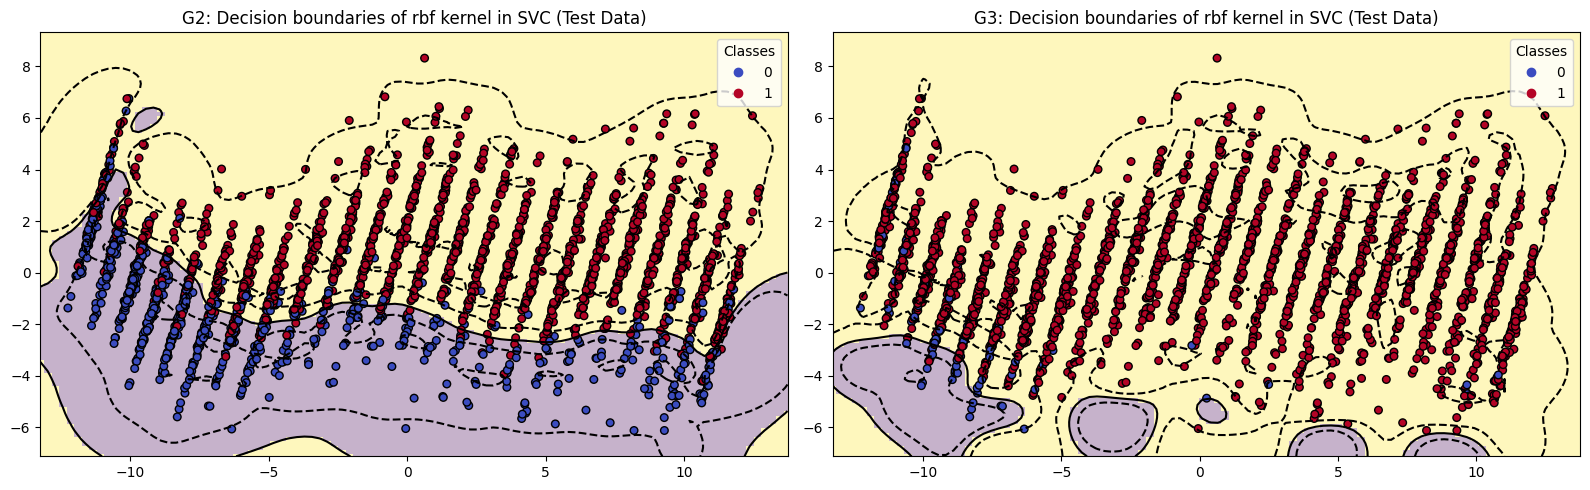

In [51]:
# # PCA with 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Split X_pca for training and testing
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, targets, test_size=0.2, random_state=42)

# Explained Variance
print("Explained Variance of the components:", pca.explained_variance_ratio_)
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.4f}")

# # Pairplot for my 2 PCA components
# df = pd.DataFrame(X_pca, columns=["PCA1", "PCA2"])
# df["Target"] = y_train["G2"]
# sns.pairplot(df, hue="Target")

# Run function
plot_decision_boundary_multi(kernel="rbf", X_train=X_train_pca, y_train=y_train, X_test=X_test_pca, y_test=y_test, classification=True, test=True)

##### t-SNE with 2 components

Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.76      0.79      0.77       739
         1.0       0.90      0.89      0.90      1661

    accuracy                           0.86      2400
   macro avg       0.83      0.84      0.84      2400
weighted avg       0.86      0.86      0.86      2400

MCC for G2: 0.672

Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        90
         1.0       0.96      1.00      0.98      2310

    accuracy                           0.96      2400
   macro avg       0.48      0.50      0.49      2400
weighted avg       0.93      0.96      0.94      2400

MCC for G3: 0.000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

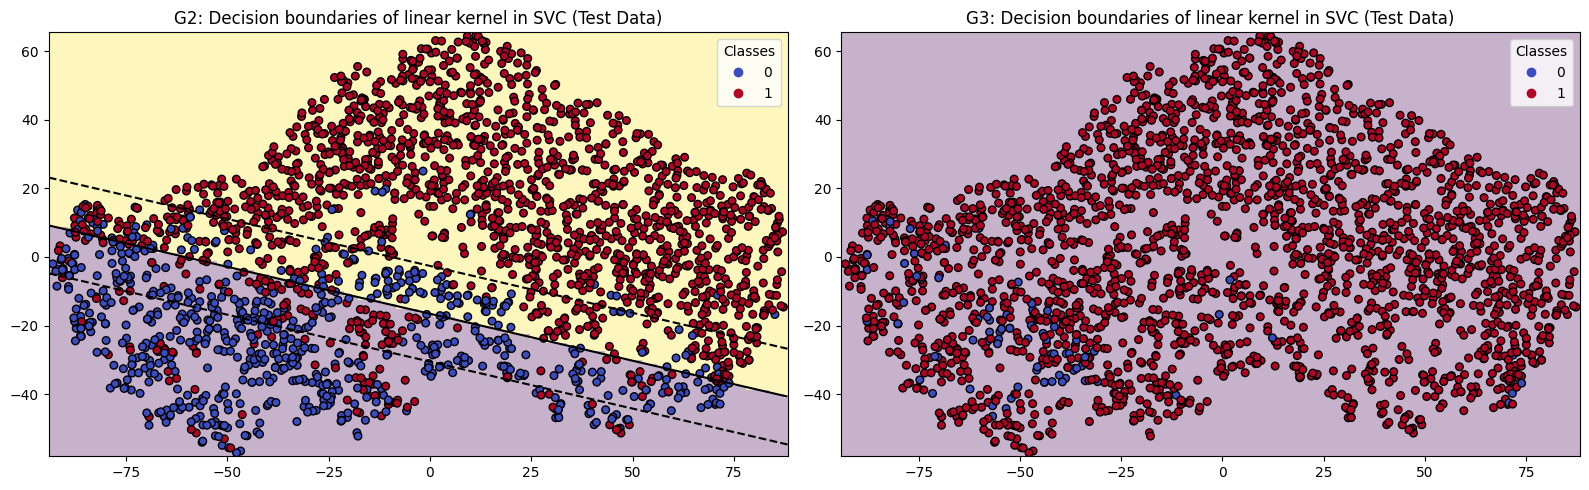

In [52]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(features)

# Use X_tsne for training and testing
X_train_tsne, X_test_tsne, y_train, y_test = train_test_split(X_tsne, targets, test_size=0.2, random_state=42)

# Plot with t-SNE-transformed data
plot_decision_boundary_multi(kernel="linear", X_train=X_train_tsne, y_train=y_train, X_test=X_test_tsne, y_test=y_test, classification=True, test=True)

##### Kernel PCA with 2 components

Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.65      0.68      0.66       739
         1.0       0.85      0.84      0.84      1661

    accuracy                           0.79      2400
   macro avg       0.75      0.76      0.75      2400
weighted avg       0.79      0.79      0.79      2400

MCC for G2: 0.507

Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        90
         1.0       0.96      1.00      0.98      2310

    accuracy                           0.96      2400
   macro avg       0.48      0.50      0.49      2400
weighted avg       0.93      0.96      0.94      2400

MCC for G3: -0.004



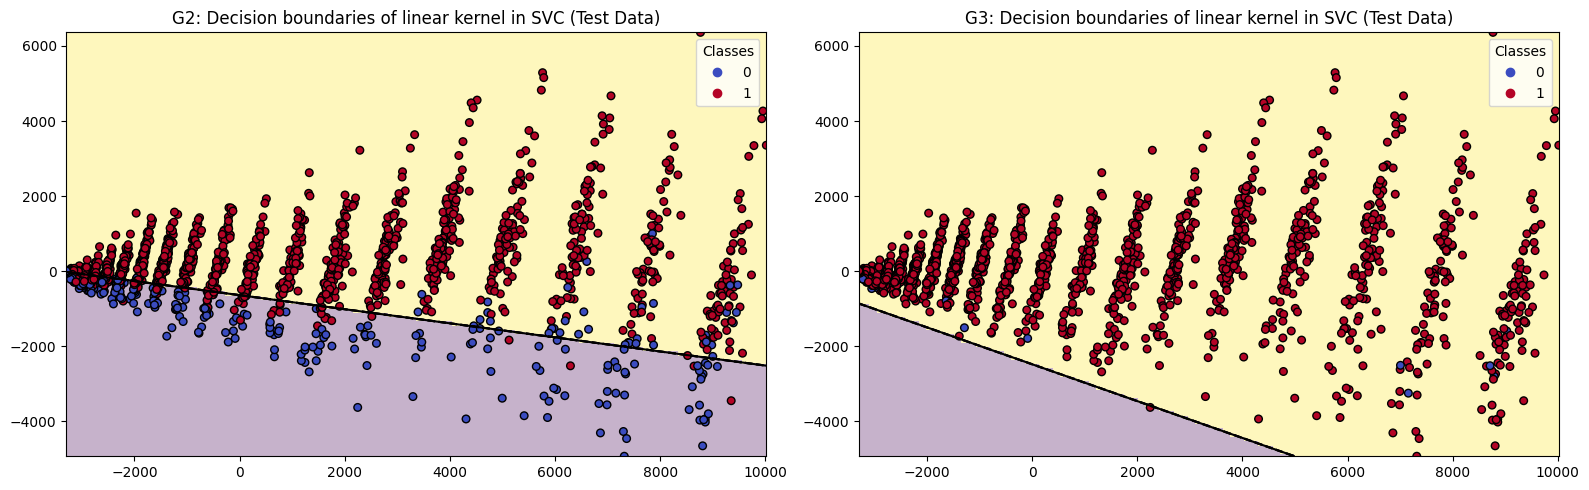

In [53]:
# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='poly', gamma=1)
X_kpca = kpca.fit_transform(features)

# Use X_kpca for training and testing
X_train_kpca, X_test_kpca, y_train, y_test = train_test_split(X_kpca, targets, test_size=0.2, random_state=42)

# Plot with X_kpca
plot_decision_boundary_multi(kernel="linear", X_train=X_train_kpca, y_train=y_train, X_test=X_test_kpca, y_test=y_test, classification=True, test=True)

##### UMAP with 2 components

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.70      0.65      0.67       739
         1.0       0.85      0.88      0.86      1661

    accuracy                           0.80      2400
   macro avg       0.77      0.76      0.77      2400
weighted avg       0.80      0.80      0.80      2400

MCC for G2: 0.533

Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        90
         1.0       0.96      1.00      0.98      2310

    accuracy                           0.96      2400
   macro avg       0.48      0.50      0.49      2400
weighted avg       0.93      0.96      0.94      2400

MCC for G3: 0.000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

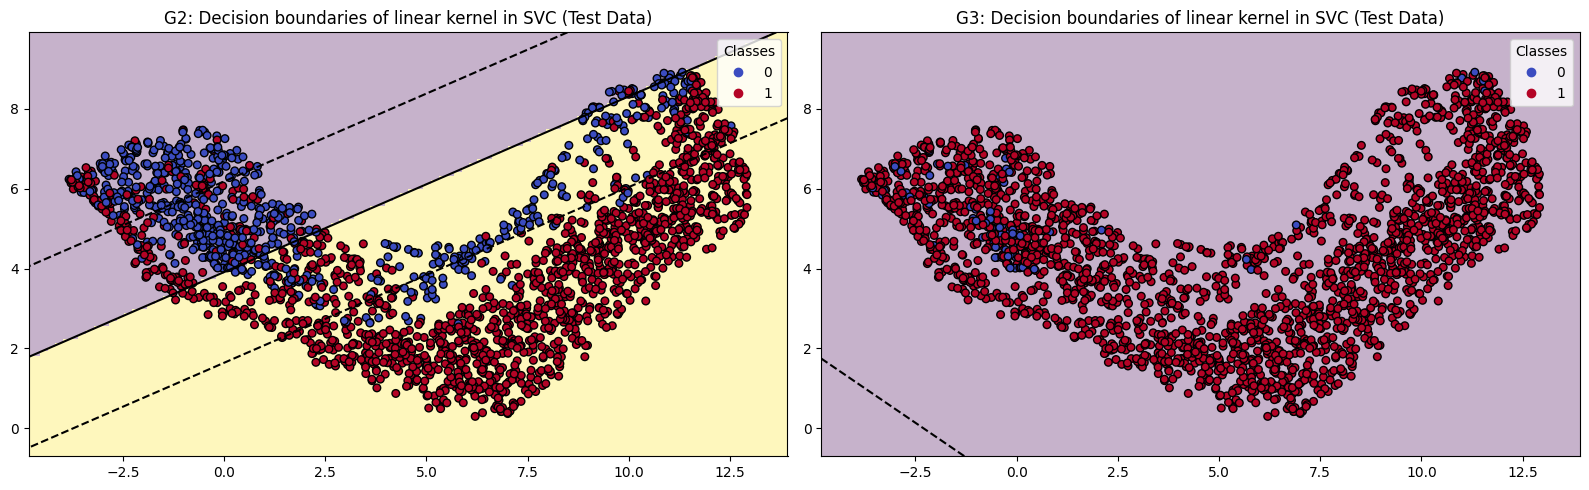

In [54]:
# Apply UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

# Use X_umap3 for training and testing
X_train_umap, X_test_umap, y_train, y_test = train_test_split(X_umap, targets, test_size=0.2, random_state=42)

# Plot with UMAP-transformed data
plot_decision_boundary_multi(kernel="linear", X_train=X_train_umap, y_train=y_train, X_test=X_test_umap, y_test=y_test, test=True)

### **3-D Plot**

In [55]:
from mpl_toolkits.mplot3d import Axes3D

def plot_decision_boundary_3d(
    kernel, X_train, y_train, X_test=None, y_test=None, 
    labels=None, classification=True, test=False, gamma=0.5, C=30):
    """
    Plot 3D decision boundaries and classification reports for multi-label data.

    Parameters:
    - kernel: Kernel type for SVC.
    - X_train: Training feature data (3D for plotting).
    - y_train: Training target data (DataFrame or dict-like structure).
    - X_test: Test feature data (optional, used if test=True).
    - y_test: Test target data (optional, used if test=True).
    - labels: List of labels to plot and analyze (e.g., ["G2", "G3"]).
    - classification: Whether to print classification reports and MCC.
    - test: If True, plots and reports are generated for test data.
    - gamma: RBF kernel coefficient.
    - C: Regularization parameter.
    """
    # Select data for plotting
    X = X_test if test else X_train
    y = y_test if test else y_train

    if labels is None:
        labels = y.columns  # Use all columns in y if no labels are provided

    # Create subplots for each label
    num_labels = len(labels)
    fig = plt.figure(figsize=(10 * num_labels, 7))

    for i, label in enumerate(labels):
        # Train the SVC for the current label
        clf = SVC(kernel=kernel, gamma=gamma, C=C).fit(X_train, y_train[label])
        y_pred = clf.predict(X)

        # Print classification report and MCC
        if classification:
            true_values = y[label]
            print(f"Classification Report for {label} ({'Test' if test else 'Train'} Data):")
            print(classification_report(true_values, y_pred))
            mcc = matthews_corrcoef(true_values, y_pred)
            print(f"MCC for {label}: {mcc:.3f}\n")

        # Create a 3D plot
        ax = fig.add_subplot(1, num_labels, i + 1, projection='3d')

        # Define a grid for plotting the decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 30),
            np.linspace(y_min, y_max, 30),
        )
        zz = np.zeros_like(xx)

        # Evaluate decision function for the grid (only for linear kernels)
        if kernel == "linear":
            for j in range(xx.shape[0]):
                for k in range(xx.shape[1]):
                    zz[j, k] = -(
                        clf.coef_[0][0] * xx[j, k] + clf.coef_[0][1] * yy[j, k] + clf.intercept_
                    ) / clf.coef_[0][2]

        # Plot decision boundary surface
        if kernel == "linear":
            ax.plot_surface(xx, yy, zz, alpha=0.3, cmap="coolwarm")

        # Plot the training samples
        ax.scatter(
            X[:, 0], X[:, 1], X[:, 2], c=y[label], s=50, cmap="coolwarm", edgecolors="k"
        )

        # Add labels and title
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Feature 3")
        ax.set_title(f"{label}: Decision boundaries of {kernel} kernel in SVC ({'Test' if test else 'Train'} Data)")

    plt.tight_layout()
    plt.show()


##### PCA with 3 components

Explained Variance of the components: [0.74272236 0.07045559 0.04491722]
Total Explained Variance: 0.8581
Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.79       739
         1.0       0.90      0.91      0.91      1661

    accuracy                           0.87      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.87      0.87      0.87      2400

MCC for G2: 0.696



/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_54847/3970525424.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[j, k] = -(


Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        90
         1.0       0.96      1.00      0.98      2310

    accuracy                           0.96      2400
   macro avg       0.48      0.50      0.49      2400
weighted avg       0.93      0.96      0.94      2400

MCC for G3: 0.000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

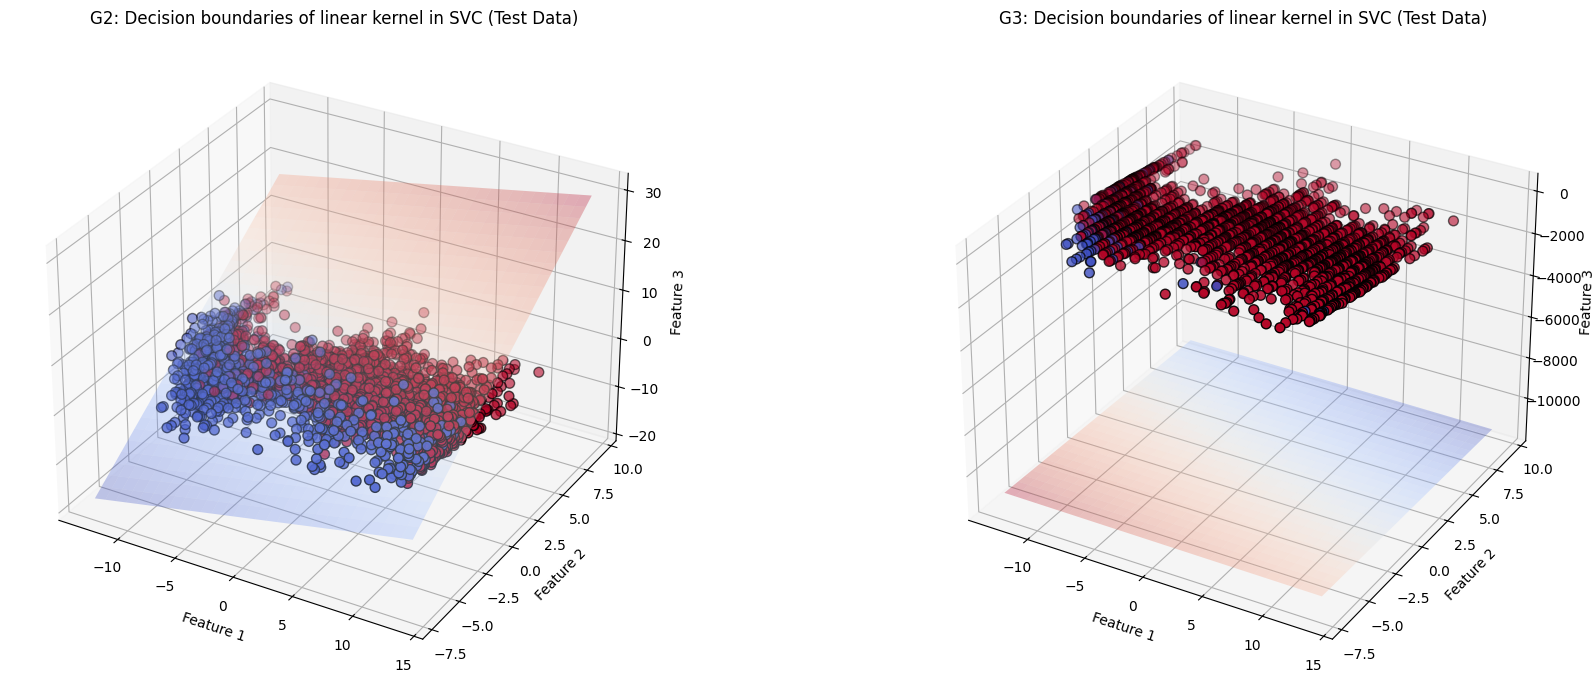

In [56]:
# PCA to reduce to 3 components
pca = PCA(n_components=3)
X_pca3 = pca.fit_transform(features)

# Split X_pca for training and testing
X_train_pca3, X_test_pca3, y_train, y_test = train_test_split(X_pca3, targets, test_size=0.2, random_state=42)

# Explained Variance
print("Explained Variance of the components:", pca.explained_variance_ratio_)
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.4f}")

# # Plot decision boundaries in 3D for test data
plot_decision_boundary_3d(kernel="linear", X_train=X_train_pca3, y_train=y_train,X_test=X_test_pca3, y_test=y_test, test=True)

##### t-SNE with 3 components

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42)
X_tsne3 = tsne.fit_transform(features)

# Use X_tsne for training and testing
X_train_tsne3, X_test_tsne3, y_train, y_test = train_test_split(X_tsne3, targets, test_size=0.2, random_state=42)

# Plot with t-SNE-transformed data
plot_decision_boundary_3d(kernel="linear", X_train=X_train_tsne3, y_train=y_train, X_test=X_test_tsne3, y_test=y_test, test=True)

##### UMAP with 3 components

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Classification Report for G2 (Test Data):
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       732
         1.0       0.90      0.93      0.92      1668

    accuracy                           0.88      2400
   macro avg       0.87      0.85      0.86      2400
weighted avg       0.88      0.88      0.88      2400

MCC for G2: 0.716



/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_53677/3970525424.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[j, k] = -(


Classification Report for G3 (Test Data):
              precision    recall  f1-score   support

         0.0       0.91      0.53      0.67        90
         1.0       0.98      1.00      0.99      2310

    accuracy                           0.98      2400
   macro avg       0.94      0.77      0.83      2400
weighted avg       0.98      0.98      0.98      2400

MCC for G3: 0.687



/var/folders/tz/wvdldxqj00gc2cslzkpx77sr0000gn/T/ipykernel_53677/3970525424.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zz[j, k] = -(


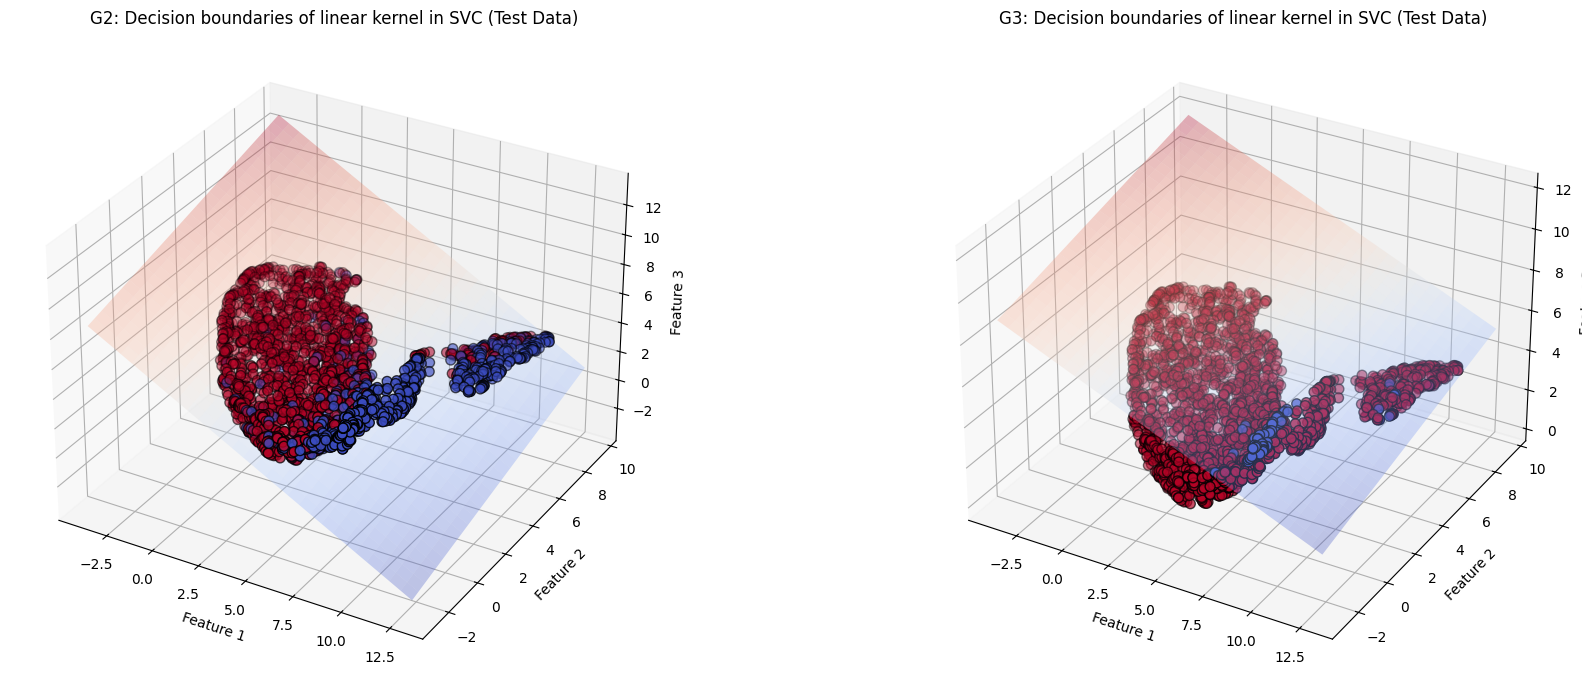

In [ ]:
# Apply UMAP
umap = UMAP(n_components=3, random_state=42) #fine-tuning: UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap3 = umap.fit_transform(features)

# Use X_umap3 for training and testing
X_train_umap3, X_test_umap3, y_train, y_test = train_test_split(X_umap3, targets, test_size=0.2, random_state=42)

# Plot with UMAP-transformed data
plot_decision_boundary_3d(kernel="linear", X_train=X_train_umap3, y_train=y_train, X_test=X_test_umap3, y_test=y_test, test=True)

### Lagged Version

In [ ]:
# # Logistic Regression with features_large for both labels
# log_reg = LogisticRegression(random_state=42)

# # Logistic Regression for G2
# log_reg.fit(X_train_L, y_train_L["G2"])
# y_pred = log_reg.predict(X_test_L)
# print("Logistic Regression G2:") 
# print(classification_report(y_test_L["G2"], y_pred))
# print(f"MCC: {matthews_corrcoef(y_test_L['G2'], y_pred):.3f}")

# # Logistic Regression for G3
# log_reg.fit(X_train_L, y_train_L["G3"])
# y_pred = log_reg.predict(X_test_L)
# print("Logistic Regression G3:") 
# print(classification_report(y_test_L["G3"], y_pred))
# print(f"MCC: {matthews_corrcoef(y_test_L['G3'], y_pred):.3f}")


Logistic Regression G2:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       739
         1.0       0.96      0.97      0.97      1661

    accuracy                           0.95      2400
   macro avg       0.95      0.94      0.94      2400
weighted avg       0.95      0.95      0.95      2400

MCC: 0.888
Logistic Regression G3:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92        90
         1.0       1.00      1.00      1.00      2310

    accuracy                           0.99      2400
   macro avg       0.97      0.95      0.96      2400
weighted avg       0.99      0.99      0.99      2400

MCC: 0.918
